# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm
import iteration_utilities
import statsmodels
import scipy.optimize
import scipy.spatial.distance as sd
from lmfit import *
from matplotlib.lines import Line2D

mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["pdf.fonttype"] = 42
sns.set_style(
    "ticks",
    {
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "font_color": "k",
        "axes.edgecolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)
sns.set_context("talk", font_scale=1.0)

# Loading Data

In [2]:
df1 = pd.read_csv(
    "../02_repressor_validations/2021.11.17_repression_round1/data/all_cells_live_mch_gated.csv"
)
df2 = pd.read_csv(
    "../02_repressor_validations/2022.04.18_repadd_stapl/data/all_cells_mch_live.csv"
)
df2 = df2[df2['asv']==0]
dfx = pd.concat([df1, df2])
dfx.head()

,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry,asv
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,14387968.0,85923072.0,59,1.0,none,True,True,NaN
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,104767232.0,66599936.0,59,1.0,none,True,True,NaN
2,4.226458e+08,101837056.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,26209536.0,61377280.0,59,1.0,none,False,True,NaN
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,365425920.0,376630272.0,59,1.0,none,True,True,NaN
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,180713472.0,1863680.0,59,1.0,none,True,True,NaN


In [3]:
df = dfx[dfx["P1"]]
df = df[df["mCherry"]]
df = df[df["treatment"] == "none"]
df = df.drop(
    ["FSC 488/10-A", "SSC 488/10-A", "mCherry-A", "P1", "mCherry", "treatment", "asv"],
    axis=1,
)

In [4]:
print(df.shape)
df.head()

(3748922, 6)


,day,description,dox,mCitrine-A,plasmid,replicate
0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,85923072.0,59,1.0
1,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,66599936.0,59,1.0
3,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,376630272.0,59,1.0
4,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,1863680.0,59,1.0
5,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,183085824.0,59,1.0


# Computing Norm D2 Off

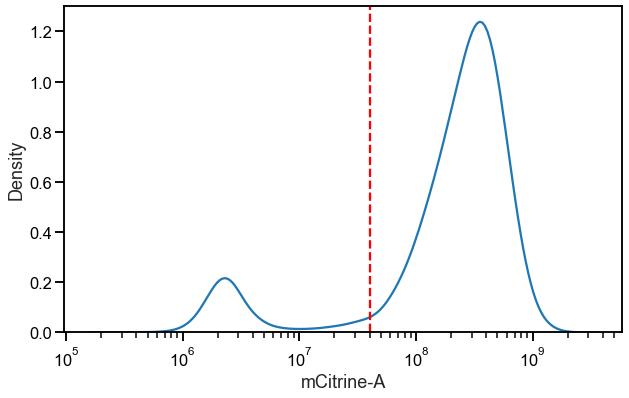

In [5]:
g = sns.kdeplot(
    data=df[(df["day"] == 2) & (df["plasmid"] == 126)], x="mCitrine-A", log_scale=True
)
g.axvline(4e7, color='red', linestyle='--')
citrine_threshold = 4e7

In [6]:
gdf = df[df["day"] == 2]
gdf['citrine OFF'] = gdf['mCitrine-A'] < citrine_threshold
mdf = (
    gdf.groupby(["day", "plasmid", "description", "replicate", "dox"])
    .mean()
    .reset_index()
)
mdf = mdf.pivot(
    index=["plasmid", "description", "replicate"], columns="dox", values="citrine OFF"
).reset_index()
mdf['norm_off'] = (mdf[1000.0]-mdf[0.0])/(1.0-mdf[0.0])
mdf = mdf.groupby(['plasmid', 'description']).mean().reset_index()
mdf = mdf[['plasmid', 'description', 'norm_off']]
mdf.head()

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_78123/692736120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['citrine OFF'] = gdf['mCitrine-A'] < citrine_threshold


dox,plasmid,description,norm_off
0,59,ZIK1 KRAB + Rand Ctrl 89,0.855057
1,61,KMT2C Dual + FOXO3 TAD,0.432341
2,63,KMT2D Dual + ZNF10 KRAB,0.809164
3,65,KMT2D Dual + Rand Ctrl 89,0.006181
4,72,Rand Ctrl + Rand Ctrl 89,0.005792


# Comparing to Screen Score

In [7]:
screen_data = pd.read_csv('../01_repressor_additivity/pairs_baselinesums.csv')
screen_data.head()

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,2.054285,0.493242,Repressor,Non-hit,A-N,Other,True,False,1.126839,2.462512
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,0.351655,0.582309,Repressor,Activator,A-A,Activator,True,True,5.959180,0.703310
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,-0.808308,0.670493,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.745666,0.626952,Activator,Activator,A-A,Activator,True,True,5.391484,1.491332
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,1.827117,0.364559,Repressor,Non-hit,R-N,Other,False,True,-3.468438,-1.219896


In [8]:
oligos = pd.read_csv(
    "../../fig_1/01_raw_counts/csvs/base_oligo_library.csv"
)


def domain_from_gene(g):
    if g == "Rand372":
        return "Random_control;;;372;"
    elif g == "Ctrl" or g == "CTRL" or g == "DMD297":
        return "DMD_control_tiles;ENSG00000198947;;297;"
    else:
        of = oligos[oligos["Gene"] == g]
        assert len(list(of["label"])) == 1
        return list(of["label"])[0]


def get_domains(plasmid, description):
    if plasmid == 75:
        return ["DMD_control_tiles;ENSG00000198947;;297;", "Random_control;;;21;"]
    elif plasmid == 74:
        return [
            "DMD_control_tiles;ENSG00000198947;;131;",
            "DMD_control_tiles;ENSG00000198947;;297;",
        ]
    elif plasmid == 78:
        return ["Random_control;;;205;", "Random_control;;;410;"]
    # find the domain for each of the elements
    if " - " not in description:
        print(plasmid, description)
    d1, d2 = description.split(" - ")
    return [domain_from_gene(d1), domain_from_gene(d2)]

In [9]:
pdf = mdf[(mdf['plasmid'] > 73)&(mdf['plasmid']<100)]
pdf.head()

dox,plasmid,description,norm_off
5,74,DMD - DMD,0.004794
6,75,DMD - RANDCTRL,0.012940
7,76,ZNF10 - ANM2,0.744235
8,77,ZNF10 - CBX1,0.758276
9,78,RANDCTRL - RANDCTRL,0.009301


In [10]:
pairs = [
    get_domains(p, d)
    for p, d in zip(list(pdf["plasmid"]), list(pdf["description"]))
]
pdf["domain1"] = [p[0] for p in pairs]
pdf["domain2"] = [p[1] for p in pairs]
pdf["pair"] = [p[0] + " --- " + p[1] for p in pairs]
pdf

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_78123/570656686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["domain1"] = [p[0] for p in pairs]
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_78123/570656686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["domain2"] = [p[1] for p in pairs]
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_78123/570656686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

dox,plasmid,description,norm_off,domain1,domain2,pair
5,74,DMD - DMD,0.004794,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,DMD_control_tiles;ENSG00000198947;;131; --- DM...
6,75,DMD - RANDCTRL,0.012940,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,DMD_control_tiles;ENSG00000198947;;297; --- Ra...
7,76,ZNF10 - ANM2,0.744235,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Human_KRAB_variant;P21506;146 --- Short_nuclea...
8,77,ZNF10 - CBX1,0.758276,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,Human_KRAB_variant;P21506;146 --- Short_nuclea...
9,78,RANDCTRL - RANDCTRL,0.009301,Random_control;;;205;,Random_control;;;410;,Random_control;;;205; --- Random_control;;;410;
10,79,ANM2 - KIBRA,0.063312,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Short_nuclear_domain;KIBRA_HUMAN;WW;1;29,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...
11,80,BIN1 - FOXO3,0.504898,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...
12,81,CACO1 - ANM2,0.004201,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...
13,82,CREM - MPP8,0.696496,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...
14,83,DPF1 - HSF2,0.423282,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;71,Silencer_tiles;ENSG00000025156;13,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;7...


In [11]:
jdf = pdf.set_index('pair').join(
    screen_data.set_index('pair'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
jdf

,pair,plasmid,description,norm_off,domain1,domain2,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,...,d2_med_d5,d2_sd_d5,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5
0,DMD_control_tiles;ENSG00000198947;;131; --- DM...,74,DMD - DMD,0.004794,DMD_control_tiles;ENSG00000198947;;131;,DMD_control_tiles;ENSG00000198947;;297;,2 control Pair,-1.357524,2.056711,-1.241566,...,NaN,NaN,Control,Control,C-C,Control,False,False,NaN,NaN
1,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,75,DMD - RANDCTRL,0.012940,DMD_control_tiles;ENSG00000198947;;297;,Random_control;;;21;,2 control Pair,-1.657747,1.840322,-1.086945,...,-0.117011,1.669026,Control,Control,C-C,Control,False,False,NaN,NaN
2,Human_KRAB_variant;P21506;146 --- Short_nuclea...,76,ZNF10 - ANM2,0.744235,Human_KRAB_variant;P21506;146,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,-3.060923,-4.044540,-2.337508,...,1.788448,0.450569,Activator,Activator,R-A,Both,False,True,-2.290708,-1.310415
3,Human_KRAB_variant;P21506;146 --- Short_nuclea...,77,ZNF10 - CBX1,0.758276,Human_KRAB_variant;P21506;146,Short_nuclear_domain;CBX1_HUMAN;Chromo_shadow;...,0 control Pair,-2.264251,0.231829,-3.559901,...,-2.750528,0.642879,Repressor,Repressor,R-R,Repressor,False,True,-5.247002,-5.849392
4,Random_control;;;205; --- Random_control;;;410;,78,RANDCTRL - RANDCTRL,0.009301,Random_control;;;205;,Random_control;;;410;,2 control Pair,-1.120361,1.508892,-1.687775,...,0.732395,1.717955,Control,Control,C-C,Control,False,False,-2.929481,0.671557
5,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...,79,ANM2 - KIBRA,0.063312,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,Short_nuclear_domain;KIBRA_HUMAN;WW;1;29,0 control Pair,4.416198,1.958100,5.855841,...,1.018976,0.882401,Activator,Activator,A-A,Activator,True,False,1.468227,2.807424
6,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...,80,BIN1 - FOXO3,0.504898,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63,Short_nuclear_domain;FOXO3_HUMAN;FOXO-TAD;584;41,0 control Pair,2.926735,-1.220991,3.253456,...,0.111979,0.639032,Activator,Activator,N-A,Other,True,True,1.652464,0.973390
7,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,81,CACO1 - ANM2,0.004201,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45,0 control Pair,4.309588,1.814068,4.888535,...,1.788448,0.450569,Activator,Activator,A-A,Activator,True,False,-0.510206,3.103688
8,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...,82,CREM - MPP8,0.696496,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50,0 control Pair,-1.755332,-3.464165,-1.591981,...,-2.822486,1.093412,Repressor,Repressor,R-R,Repressor,False,True,-4.930051,-3.492127
9,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;7...,83,DPF1 - HSF2,0.423282,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;71,Silencer_tiles;ENSG00000025156;13,0 control Pair,-6.253982,1.292979,-1.753450,...,-2.197255,0.920288,Repressor,Repressor,N-R,Other,False,False,-3.705778,0.346046


# Fitting Sigmoids to Correlation

(-0.05, 1.05)

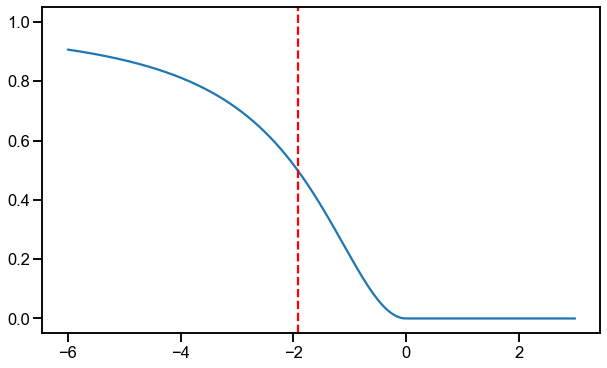

In [12]:
from scipy.optimize import curve_fit


def f_sigmoid(s, thresh, kd, n):
    if isinstance(s, int) or isinstance(s, float):
        s = np.array([s])
    elif isinstance(s, list):
        s = np.array(s)
    # else we assume np array
    res = [0 for _ in s]
    for i, v in enumerate(s):
        if v <= thresh:
            res[i] = 1 - 1 / (1 + ((v + thresh) / (kd)) ** n)
    return res


def n_sigmoid(s, t, kd, n):
    res = [0 for _ in s]
    for i, v in enumerate(s):
        if v >= t:
            res[i] = 0
        else:
            res[i] = 1 - 1 / (1 + ((v - t) / (kd - t)) ** n)
    return res


params = [0, -1.92296824, 2.0]

fig, ax = plt.subplots()
x = np.linspace(-6, 3, 1000)
y = n_sigmoid(x, *params)
ax.plot(x, y)
ax.axvline(params[1], color="r", ls="--")
ax.set_ylim(-0.05, 1.05)

In [13]:
sigdf = jdf.dropna(subset=["avg_enrichment_d5", "norm_off"])
popt, _ = curve_fit(
    f=n_sigmoid,
    xdata=np.array(list(sigdf["avg_enrichment_d5"])),
    ydata=np.array(list(sigdf["norm_off"])),
    p0=[0, -2.5, 2.5],
    bounds=[[-3, -6, 2], [3, 0, 10]],
    method="dogbox",
)

print(popt)

[ 3.         -1.54340078  2.51971539]


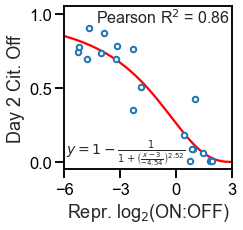

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=jdf,
    x="avg_enrichment_d5",
    y="norm_off",
    marker="o",
    edgecolor="tab:blue",
    linewidth=2,
    color="white",
    s=30,
    ax=ax,
)

ax.set_xlim(-6, 3)
ax.set_xticks([-6, -3, 0, 3])
ax.set_ylim(-0.05, 1.05)
ax.set_yticks([0, 0.5, 1.0])

ax.plot(
    np.linspace(-6, 3, 1000),
    n_sigmoid(np.linspace(-6, 3, 1000), *popt),
    color="red",
    zorder=-10,
)


xdf = jdf.dropna(subset=["avg_enrichment_d5", "norm_off"])
r, p = st.pearsonr(xdf["avg_enrichment_d5"], xdf["norm_off"])
ax.text(-4.3, 0.935, "Pearson R$^2$ = {:.2f}".format(r**2), fontsize=16)
ax.text(
    x=-5.9,
    y=0.05,
    s="$y=1-\\frac{1}{1 + \\left( \\frac{x-3}{-4.54} \\right)^{2.52}}}$",
    # t$=0$\nh$=2.36$\nn$=3.00$",
    fontsize=14,
)

ax.set_xlabel("Repr. log$_2$(ON:OFF)")
ax.set_ylabel("Day 2 Cit. Off")

fig.savefig("./repr_sigmoid.pdf", bbox_inches="tight")

# Making some histograms

In [37]:
hdf = df[df['plasmid'].isin([76, 80, 87])]
hdf = hdf[hdf['day'].isin([0, 2])]
hdf.describe()

,day,dox,mCitrine-A,plasmid,replicate
count,61030.000000,61030.000000,6.103000e+04,61030.000000,61030.000000
mean,1.036539,381.271506,2.526661e+08,81.994200,1.496477
std,0.999340,485.703006,2.251689e+08,4.638852,0.499992
min,0.000000,0.000000,4.451840e+05,76.000000,1.000000
25%,0.000000,0.000000,5.678810e+07,76.000000,1.000000
50%,2.000000,0.000000,2.137277e+08,80.000000,1.000000
75%,2.000000,1000.000000,3.782575e+08,87.000000,2.000000
max,2.000000,1000.000000,2.147483e+09,87.000000,2.000000


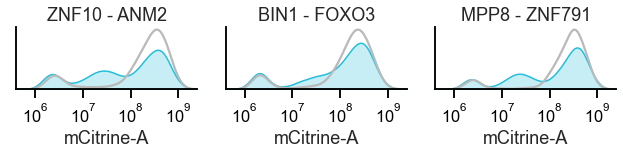

In [56]:
plasmids = [76, 80, 87]
fig, ax = plt.subplots(1, len(plasmids), figsize=(3*len(plasmids), 2.5))

for i, a in enumerate(ax.flat):
    adf = hdf[hdf['plasmid']==plasmids[i]]
    descr = list(adf['description'])[0]
    sns.kdeplot(
        data = adf[adf['day']==0],
        x = 'mCitrine-A',
        hue = 'day',
        palette = ['#bababa'],
        log_scale = True,
        fill = False,
        legend = False,
        ax=a
    )
    sns.kdeplot(
        data = adf[adf['day']==2],
        x = 'mCitrine-A',
        hue = 'day',
        palette = ['#23bedb'],
        log_scale = True,
        fill = True,
        legend = False,
        ax=a
    )
    a.set_title(descr)
    a.set_yticks([])
    a.set_ylabel("")
    a.set_xlim(4e5, 2.5e9)
    a.set_xticks([1e6, 1e7, 1e8, 1e9])
#    a.set_xscale('log')

sns.despine(fig)
plt.tight_layout()

# Sigmoid Comparison Plot

In [65]:
def rep_fun(e):
    return n_sigmoid(e, *popt)

In [82]:
rsdf = screen_data[screen_data['composition'].isin(['C-C', 'R-R'])]
rsdf['rep_est_d2_off'] = rep_fun(rsdf['avg_enrichment_d5'])

group_labels = [
    "Neg. Ctrl Domain Pairs",
    "Low Expected Repression",
    "Med Expected Repression",
    "High Expected Repression",
]


def get_act_group(s, c):
    if c == "C-C":
        return group_labels[0]
    elif s >= -2.5:
        return group_labels[1]
    elif s >= -5:
        return group_labels[2]
    else:
        return group_labels[3]


rsdf["rep_group"] = [
    get_act_group(s, c)
    for s, c in zip(rsdf["baseline_sum_d5"], rsdf["composition"])
]

rsdf.head()

/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_78123/2757188195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsdf['rep_est_d2_off'] = rep_fun(rsdf['avg_enrichment_d5'])
/var/folders/dc/w29p98q54dv6v4wg20gnvzg40000gn/T/ipykernel_78123/2757188195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsdf["rep_group"] = [


,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d2_description,d2_baseline_type,composition,character,act_pair_hit,rep_pair_hit,baseline_sum_d2,baseline_sum_d5,rep_est_d2_off,rep_group
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,Repressor,Repressor,R-R,Repressor,False,True,-3.901673,-1.616616,0.555998,Low Expected Repression
12,Silencer_tiles;ENSG00000076108;118 --- Silence...,0 control Pair,-2.990265,-2.355584,-2.394019,-1.797338,0.111779,0.163452,0.159842,0.223425,...,Repressor,Repressor,R-R,Repressor,False,True,-3.559434,-3.521088,0.569432,Med Expected Repression
74,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-3.737496,-3.608713,-3.231400,-4.343375,0.069744,0.075762,0.096230,0.046949,...,Repressor,Repressor,R-R,Repressor,False,True,-4.360371,-6.094026,0.746583,High Expected Repression
139,Silencer_tiles;ENSG00000102974;12 --- Silencer...,0 control Pair,-2.075843,-1.086197,-1.390100,-2.046392,0.191721,0.320191,0.276169,0.194905,...,Repressor,Repressor,R-R,Repressor,False,True,-4.168971,-3.686659,0.503166,Med Expected Repression
155,Silencer_tiles;ENSG00000076108;118 --- Silence...,0 control Pair,-1.482400,-1.980740,-1.833394,-2.754721,0.263565,0.202145,0.219118,0.129045,...,Repressor,Repressor,R-R,Repressor,False,True,-3.828406,-3.023110,0.603510,Med Expected Repression


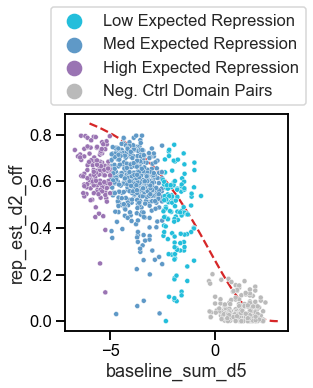

In [90]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(
    data = rsdf,
    x = 'baseline_sum_d5',
    y = 'rep_est_d2_off',
    hue = 'rep_group',
    palette = ['#23bedb', '#5f99c7', '#9a74b3', '#bababa'],
    s = 25,
    ax=ax
)

xvals = np.linspace(-6, 3, 1000)
yvals = rep_fun(xvals)
ax.plot(xvals, yvals, ls='--', color='tab:red', zorder=-10)

l = ax.legend(loc="lower left", bbox_to_anchor=(-0.1, 1))
for m in l.legendHandles:
    m._sizes = [200]